# Extracting Tybalt Weights

The weights learned by the Tybalt model indicate patterns of gene expression variably activated across tumors. As Tybalt is an unsupervised model, these weights learned can point to known biology, unknown biology, or unrelated noise. One of the benefits of a variational autoencoder (VAE), is that the weights learned that represent each encoding are  nonlinear. Therefore, they can extract out signal representative of noise while still retaining relevant known and unknown biology.

Here, we extract the weights learned by the VAE and save them to file. We also explore specific signals that should be present in the data:

1. Signals representing the sex of the patient
2. Melanoma activation patterns.

In [1]:
import os
import pandas as pd
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
sns.set(style='white', color_codes=True)
sns.set_context('paper', rc={'font.size':8, 'axes.titlesize':10, 'axes.labelsize':15})   

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')

Because of the complex architecture involved in encoding the data, we will use the `decoded` weights to describe feature encoding specific activation patterns

In [4]:
# Load the decoder model
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae.hdf5')
decoder = load_model(decoder_model_file)

/data/katrina/anaconda3/envs/tybalt/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
# Load RNAseq file
rnaseq_file = os.path.join('Data2', 'idseq_scaled_zeroone_rnaseq.tsv.gz') #'b_cells_human_counts.norm.mad.csv.gz')#'10x_scaled_zeroone_rnaseq.tsv.gz')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
print(rnaseq_df.shape)
rnaseq_df.head(2)

(1143, 5000)


,11244,1868215,ENSG00000229807.9,586,Uncategorized,12059,12058,1903414,ENSG00000067048.16,ENSG00000202198.1,...,ENSG00000042317.16,ENSG00000117215.14,ENSG00000149179.13,ENSG00000018699.11,ENSG00000112742.9,ENSG00000116649.9,ENSG00000119227.7,ENSG00000141698.16,ENSG00000103811.15,ENSG00000100234.11
CHRF_RNA_0001_S1,0.0,0.0,0.476274,0.014692,0.623816,0.0,0.005011,0.018620,0.423272,0.396269,...,0.684292,0.804572,0.837691,0.733657,0.676144,0.705043,0.758952,0.719158,0.688606,0.76363
CHRF_RNA_0002_S2,0.0,0.0,0.436772,0.002053,0.461708,0.0,0.000000,0.005042,0.437189,0.348781,...,0.846956,0.506130,0.674280,0.905055,0.977248,0.512239,0.543441,0.519312,0.547809,0.58246


In [6]:
'''# For a future pathway analysis, the background genes are important
# Also needed to set column names on weights
background_file = os.path.join('data', 'background_genes.txt')
background_genes = pd.DataFrame(rnaseq_df.columns)
background_genes.to_csv(background_file, index=False, header=False, sep='\t')'''

"# For a future pathway analysis, the background genes are important\n# Also needed to set column names on weights\nbackground_file = os.path.join('data', 'background_genes.txt')\nbackground_genes = pd.DataFrame(rnaseq_df.columns)\nbackground_genes.to_csv(background_file, index=False, header=False, sep='\t')"

## Extract Tybalt weight matrix and write to file

In [7]:
# Extract the weights from the decoder model
weights = []
for layer in decoder.layers:
    weights.append(layer.get_weights())
    
weight_layer_df = pd.DataFrame(weights[1][0], columns=rnaseq_df.columns, index=range(1,51))#26)) #101
weight_layer_df.index.name = 'encodings'
weight_layer_df.head(2)

,11244,1868215,ENSG00000229807.9,586,Uncategorized,12059,12058,1903414,ENSG00000067048.16,ENSG00000202198.1,...,ENSG00000042317.16,ENSG00000117215.14,ENSG00000149179.13,ENSG00000018699.11,ENSG00000112742.9,ENSG00000116649.9,ENSG00000119227.7,ENSG00000141698.16,ENSG00000103811.15,ENSG00000100234.11
encodings,,,,,,,,,,,,,,,,,,,,,
1,-0.177277,-0.177094,-0.021533,-0.070261,-0.031146,-0.105246,-0.096216,-0.058683,-0.004714,0.027338,...,-0.039278,-0.069570,-0.013559,-0.026801,-0.090050,0.003853,-0.061476,-0.020390,0.002920,-0.027256
2,0.052778,0.045739,-0.053904,-0.019588,-0.009198,-0.009350,-0.008970,-0.012148,0.000831,0.009164,...,-0.048915,-0.077754,-0.037824,-0.052493,-0.053511,-0.026055,-0.055310,-0.051187,-0.025887,-0.055603


In [8]:
# Write the genes to file
weight_file = os.path.join('results', 'tybalt_gene_weights.tsv')
weight_layer_df.to_csv(weight_file, sep='\t')

## Extracting example patterns learned by Tybalt

Focusing on two examples: Sex-specific and tissue-specific activation

### Sex specific activation by node 82

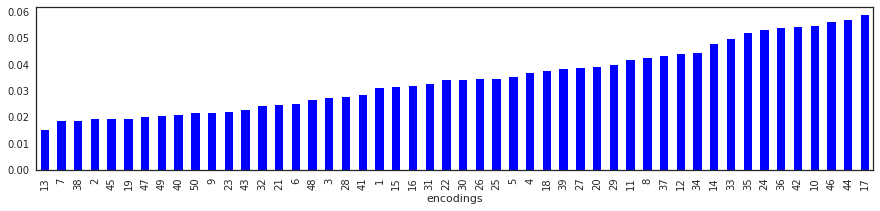

In [9]:
plt.figure(figsize=(15,3))
weight_layer_df.T.describe().loc['std'].sort_values().plot(kind='bar', color = 'blue')

Text(0.5,1,'Min (green) and Max (blue) gene loading in each latent dimension')

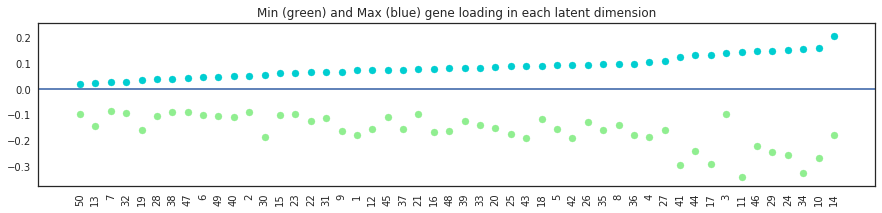

In [10]:
plt.figure(figsize=(15,3))
ser_max = weight_layer_df.T.describe().loc['max'].sort_values()
ax = plt.axes()
ax.scatter([i for i in range(len(ser_max.index))], ser_max, color = 'darkturquoise')
ser_min = weight_layer_df.T.describe().loc['min']
ser_min = ser_min[ser_max.index]
ax.scatter([i for i in range(len(ser_min.index))], ser_min, color = 'lightgreen')
ax.axhline(y = 0)
ax.set_xticks([i for i in range(len(ser_max.index))])
ax.set_xticklabels(ser_max.index, minor=False, rotation=90)
plt.title("Min (green) and Max (blue) gene loading in each latent dimension")

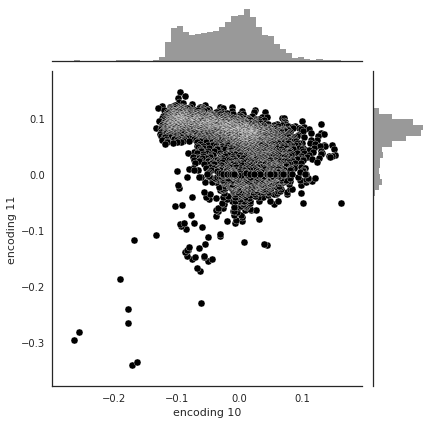

In [11]:
# MY VERSION

#sns.pairplot(weight_layer_df.loc[1:20, :].T)

# We previously identified node 82 as robustly separating sex in the data set:
# Visualize the distribution of gene weights here
A = 10
B = 11
sex_node_plot = weight_layer_df.loc[[A, B], :].T
sex_node_plot.columns = ['encoding '+str(A), 'encoding ' + str(B)]

sex_node_plot = (
    sex_node_plot.reindex(sex_node_plot['encoding ' + str(B)].abs()
                          .sort_values(ascending=False).index)
    )

g = sns.jointplot(x='encoding '+str(A), y='encoding ' + str(B),
                  data=sex_node_plot, color='black',
                  edgecolor="w", stat_func=None);

# Save Figure
sex_node_plot_file = os.path.join('figures', 'sex_node_gene_scatter.pdf')
g.savefig(sex_node_plot_file)

In [12]:
# There are 17 genes with high activation in node 82
# All genes are located on sex chromosomes
#sex_node_plot.head(17)
#sex_node_plot[sex_node_plot['encoding ' + str(B)] < -.02]

By measuring expression of only *17 genes*, we can reliably predict the sex of the cancer patient. These are genes most expressed by sex chromosomes including x inactivating genes _XIST_ and _TSIX_.

### Node separating melanoma samples

In [13]:
'''# We previously observed metastasis samples being robustly separated by two features
# Visualize the feature scores here
met_node_plot = weight_layer_df.loc[[53, 66], :].T
met_node_plot.columns = ['encoding 53', 'encoding 66']

met_node_plot = (met_node_plot.reindex(met_node_plot['encoding 53'].abs()
                                       .sort_values(ascending=False).index)
                 )
g = sns.jointplot(x='encoding 53', y='encoding 66',
                  data=met_node_plot, color='black',
                  edgecolor="w", stat_func=None);

# Save outputs
met_node_plot_file = os.path.join('figures', 'skcm_metastasis_node_gene_scatter.pdf')
g.savefig(met_node_plot_file)'''

'# We previously observed metastasis samples being robustly separated by two features\n# Visualize the feature scores here\nmet_node_plot = weight_layer_df.loc[[53, 66], :].T\nmet_node_plot.columns = [\'encoding 53\', \'encoding 66\']\n\nmet_node_plot = (met_node_plot.reindex(met_node_plot[\'encoding 53\'].abs()\n                                       .sort_values(ascending=False).index)\n                 )\ng = sns.jointplot(x=\'encoding 53\', y=\'encoding 66\',\n                  data=met_node_plot, color=\'black\',\n                  edgecolor="w", stat_func=None);\n\n# Save outputs\nmet_node_plot_file = os.path.join(\'figures\', \'skcm_metastasis_node_gene_scatter.pdf\')\ng.savefig(met_node_plot_file)'

#### Output high weight genes for two specific SKCM encodings

Because the genes involved in these nodes are not as cut and dry as the sex specific nodes, output the high weight genes explaining each tail of node 53 and 66. These will be processed though a pathway analysis downstream.

In [14]:
def output_high_weight_genes(weight_df, encoding, filename, thresh=2.5):
    """
    Function to process and output high weight genes given specific feature encodings
    """
    
    # Sort initial encoding by absolute activation
    encoding_df = (
        weight_df
        .reindex(weight_df[encoding].abs()
                 .sort_values(ascending=False).index)[encoding]
    )
    #print(encoding_df.std() * thresh)
    #print(-encoding_df.std() * thresh)
    hw_pos_df = pd.DataFrame(encoding_df[encoding_df > encoding_df.std() * thresh])
    hw_pos_df = hw_pos_df.assign(direction='positive')
    hw_neg_df = pd.DataFrame(encoding_df[encoding_df < -encoding_df.std() * thresh])
    hw_neg_df = hw_neg_df.assign(direction='negative')
    
    hw_df = pd.concat([hw_pos_df, hw_neg_df])
    hw_df.index.name = 'genes'
    hw_df.to_csv(filename, sep='\t')
    return hw_df

In [15]:
# Encoding 66
hw_node66_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
node66_df = output_high_weight_genes(sex_node_plot, 'encoding '+str(A), hw_node66_file, thresh = 3.5)
print(node66_df.shape)
node66_df#.head(30)

(2, 2)


,encoding 10,direction
genes,,
11244,-0.264680,negative
1868215,-0.255597,negative


In [16]:
# Encoding 66
hw_node66_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
node66_df = output_high_weight_genes(sex_node_plot, 'encoding '+str(B), hw_node66_file, thresh = 3.5)
print(node66_df.shape)
node66_df#.head(30)

(17, 2)


,encoding 11,direction
genes,,
ENSG00000065325.12,0.146427,positive
11158,-0.341086,negative
39744,-0.334739,negative
11244,-0.296028,negative
1868215,-0.280941,negative
12058,-0.266446,negative
12059,-0.240351,negative
906,-0.230466,negative
475,-0.186799,negative


In [17]:
# loop through all the encodings, select the "significant genes"
SD_THRESHOLD = 2.5
saved_values = {}

for i in range(51):
    A = 1
    B = i+1
    if(B > 1):
        sex_node_plot = weight_layer_df.loc[[A, B], :].T
        sex_node_plot.columns = ['encoding '+str(A), 'encoding ' + str(B)]
        sex_node_plot = (sex_node_plot.reindex(sex_node_plot['encoding ' + str(B)].abs().sort_values(ascending=False).index))
        saved_values[B] = {}

        hw_nodeA_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
        nodeA_df = output_high_weight_genes(sex_node_plot, 'encoding '+str(A), hw_nodeA_file, thresh = SD_THRESHOLD)
        nodeA_df.index

        hw_nodeB_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
        nodeB_df = output_high_weight_genes(sex_node_plot, 'encoding '+str(B), hw_nodeB_file, thresh = SD_THRESHOLD)

        for gene in nodeB_df.index:
            saved_values[B][gene] = nodeB_df.loc[gene]['encoding '+str(B)]

# FINISH ADDING THE DATA
        
A = 2
B = 1

sex_node_plot = weight_layer_df.loc[[A, B], :].T
sex_node_plot.columns = ['encoding '+str(A), 'encoding ' + str(B)]
sex_node_plot = ( sex_node_plot.reindex(sex_node_plot['encoding ' + str(B)].abs().sort_values(ascending=False).index))
saved_values[B] = {}

hw_nodeA_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
nodeA_df = output_high_weight_genes(sex_node_plot, 'encoding '+str(A), hw_nodeA_file, thresh = SD_THRESHOLD)
nodeA_df.index

hw_nodeB_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
nodeB_df = output_high_weight_genes(sex_node_plot, 'encoding '+str(B), hw_nodeB_file, thresh = SD_THRESHOLD)
for gene in nodeB_df.index:
    saved_values[B][gene] = nodeB_df.loc[gene]['encoding '+str(B)]

df = pd.DataFrame(saved_values)
df.fillna(0, inplace=True)
df.head()
#df = df[(df != 0).sum(axis=1) > 3] ## THIS HAD COOL > 0 results for LV50
df = df[(df > 0).sum(axis=1) > 0]

/data/katrina/anaconda3/envs/tybalt/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/data/katrina/anaconda3/envs/tybalt/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [18]:
df = pd.DataFrame(saved_values)
df.shape

(4973, 51)

In [19]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,42,43,44,45,46,47,48,49,50,51
11158,-0.084370,NaN,NaN,-0.183971,NaN,NaN,NaN,NaN,-0.132778,-0.171732,...,-0.172407,-0.148185,-0.223337,NaN,NaN,NaN,-0.119504,NaN,NaN,NaN
11244,-0.177277,0.052778,0.141124,-0.105837,NaN,NaN,-0.069824,NaN,-0.138284,-0.264680,...,-0.172916,-0.167116,-0.223143,-0.075293,-0.174752,NaN,-0.146927,NaN,NaN,NaN
119045,NaN,NaN,NaN,-0.140702,-0.152494,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.060269,NaN,NaN,NaN,NaN,NaN,NaN
119060,NaN,NaN,NaN,NaN,-0.133205,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.070639,-0.154217,NaN,NaN,NaN,NaN,NaN
12058,-0.096216,NaN,NaN,-0.117917,NaN,NaN,NaN,NaN,-0.154408,-0.177136,...,NaN,-0.159098,-0.152095,NaN,NaN,NaN,-0.162155,NaN,NaN,NaN


In [20]:
'''#df.loc[:,(df[(df>0).sum(axis=1) > 0] > 0).sum() < 10].head()
newdf = df[(df>0).sum(axis=1) > 0]
print(newdf.shape)
newdf.fillna(0, inplace=True)
newdf = newdf.loc[:,(newdf > 0).sum() < 100]
newdf = newdf.loc[:,(newdf > 0).sum() > 0]
newdf = newdf > 0
print(newdf.shape)
sns.clustermap(newdf)'''

'#df.loc[:,(df[(df>0).sum(axis=1) > 0] > 0).sum() < 10].head()\nnewdf = df[(df>0).sum(axis=1) > 0]\nprint(newdf.shape)\nnewdf.fillna(0, inplace=True)\nnewdf = newdf.loc[:,(newdf > 0).sum() < 100]\nnewdf = newdf.loc[:,(newdf > 0).sum() > 0]\nnewdf = newdf > 0\nprint(newdf.shape)\nsns.clustermap(newdf)'

In [21]:
for i in range(51):
    if(i > 0):
        print(i)
        test = df[i]
        test.fillna(0, inplace=True)
        pos = [i for i in test[test > 0].index]
        print('pos_total: ' + str(test[test > 0].shape[0]) + ' // pos_gene: ' + str(sum([1 for i in pos if 'ENSG' in i])) + ' // ' + 'neg: ' + str(test[test < 0].shape[0])) 
        #print(test[test > 0])
        print(pos)
        #print([i for i in test[test < 0].index])
        print('\n')

1
pos_total: 0 // pos_gene: 0 // neg: 386
[]


2
pos_total: 1 // pos_gene: 0 // neg: 2294
['11244']


3
pos_total: 8 // pos_gene: 5 // neg: 830
['11244', '1868215', 'ENSG00000134321.11', 'ENSG00000169248.12', 'ENSG00000184979.9', 'ENSG00000185745.9', 'ENSG00000187608.8', 'Viruses']


4
pos_total: 3 // pos_gene: 3 // neg: 111
['ENSG00000128271.19', 'ENSG00000268903.1', 'ENSG00000269981.1']


5
pos_total: 6 // pos_gene: 6 // neg: 21
['ENSG00000124731.12', 'ENSG00000147454.13', 'ENSG00000251139.2', 'ENSG00000254281.1', 'ENSG00000259600.2', 'ENSG00000268734.1']


6
pos_total: 0 // pos_gene: 0 // neg: 1182
[]


7
pos_total: 0 // pos_gene: 0 // neg: 2365
[]


8
pos_total: 0 // pos_gene: 0 // neg: 50
[]


9
pos_total: 2 // pos_gene: 0 // neg: 1116
['1903414', '586']


10
pos_total: 8 // pos_gene: 8 // neg: 8
['ENSG00000109472.13', 'ENSG00000135917.13', 'ENSG00000138207.12', 'ENSG00000144681.10', 'ENSG00000154783.10', 'ENSG00000163710.7', 'ENSG00000167588.12', 'ENSG00000170323.8']


11
pos_tot

pos_total: 70 // pos_gene: 70 // neg: 39
['ENSG00000000938.12', 'ENSG00000018280.16', 'ENSG00000028137.16', 'ENSG00000066336.11', 'ENSG00000069399.12', 'ENSG00000075426.11', 'ENSG00000075624.13', 'ENSG00000087074.7', 'ENSG00000090339.8', 'ENSG00000099985.3', 'ENSG00000100345.20', 'ENSG00000100906.10', 'ENSG00000108179.13', 'ENSG00000110047.17', 'ENSG00000116701.14', 'ENSG00000118503.14', 'ENSG00000119535.17', 'ENSG00000122861.15', 'ENSG00000123689.5', 'ENSG00000124102.4', 'ENSG00000124731.12', 'ENSG00000125505.16', 'ENSG00000125538.11', 'ENSG00000125753.13', 'ENSG00000127528.5', 'ENSG00000128016.5', 'ENSG00000132510.10', 'ENSG00000135821.16', 'ENSG00000137076.18', 'ENSG00000137331.11', 'ENSG00000140678.16', 'ENSG00000141480.17', 'ENSG00000143546.9', 'ENSG00000148926.9', 'ENSG00000162551.13', 'ENSG00000163220.10', 'ENSG00000163464.7', 'ENSG00000167996.15', 'ENSG00000169564.6', 'ENSG00000170458.13', 'ENSG00000170525.18', 'ENSG00000171051.8', 'ENSG00000171223.5', 'ENSG00000171236.9', 'ENS

In [22]:
print([i for i in rnaseq_df.columns if 'ENSG' in i])

['ENSG00000229807.9', 'ENSG00000067048.16', 'ENSG00000202198.1', 'ENSG00000236138.4', 'ENSG00000169894.17', 'ENSG00000115414.18', 'ENSG00000280156.1', 'ENSG00000281344.1', 'ENSG00000169429.10', 'ENSG00000251562.7', 'ENSG00000173369.15', 'ENSG00000244734.3', 'ENSG00000130203.9', 'ENSG00000260314.2', 'ENSG00000200312.1', 'ENSG00000170323.8', 'ENSG00000019582.14', 'ENSG00000148357.16', 'ENSG00000202058.1', 'ENSG00000123689.5', 'ENSG00000204287.13', 'ENSG00000121904.17', 'ENSG00000119922.8', 'ENSG00000115155.16', 'ENSG00000269028.3', 'ENSG00000275385.1', 'ENSG00000183878.15', 'ENSG00000205592.13', 'ENSG00000134321.11', 'ENSG00000175445.14', 'ENSG00000159189.11', 'ENSG00000167588.12', 'ENSG00000279184.1', 'ENSG00000119917.13', 'ENSG00000201428.1', 'ENSG00000173372.16', 'ENSG00000144681.10', 'ENSG00000113140.10', 'ENSG00000158270.11', 'ENSG00000137959.15', 'ENSG00000196126.10', 'ENSG00000186188.10', 'ENSG00000130294.14', 'ENSG00000185745.9', 'ENSG00000188536.12', 'ENSG00000255823.2', 'ENSG00

ValueError: The condensed distance matrix must contain only finite values.

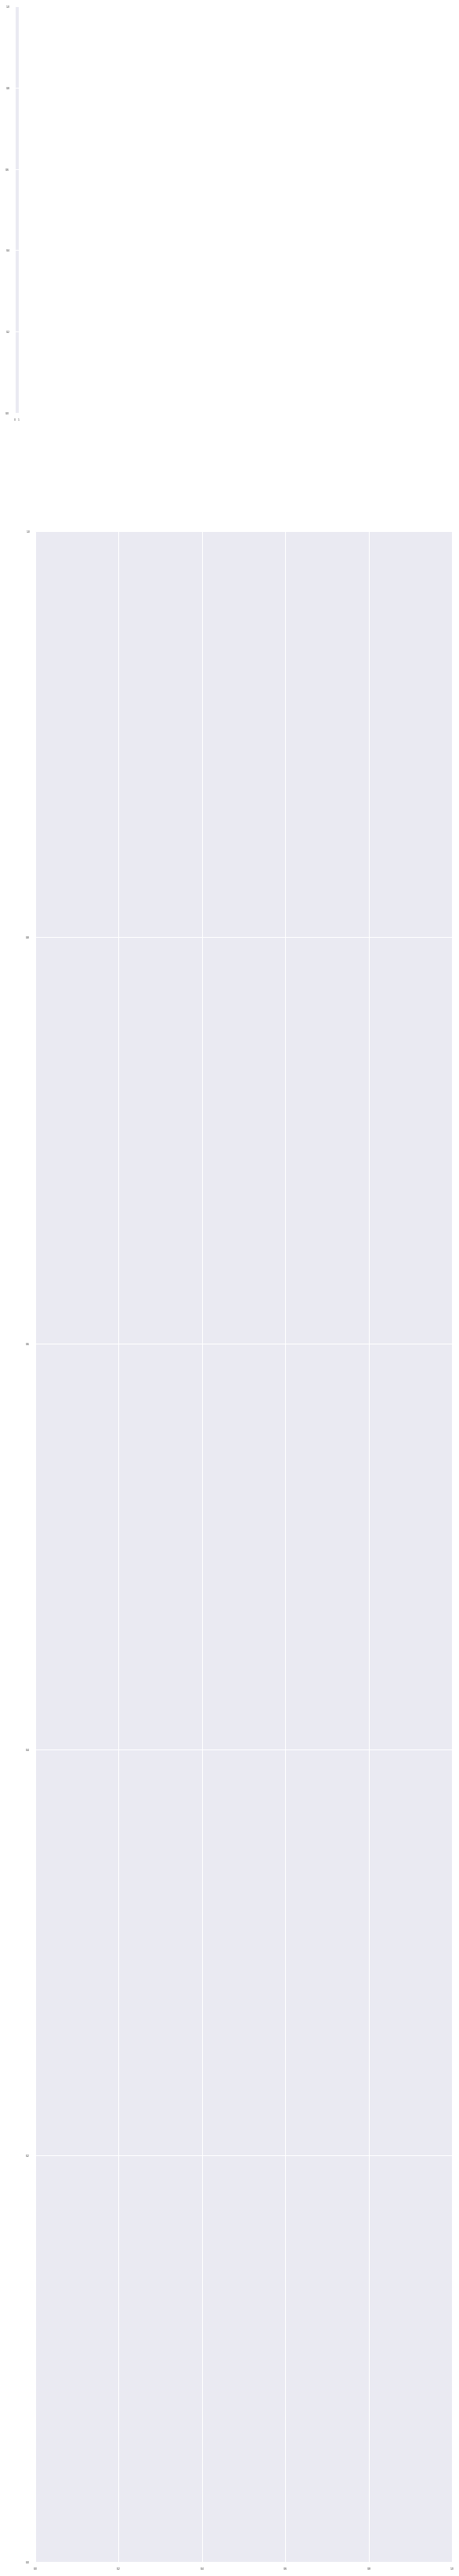

In [23]:
sns.set(font_scale=0.3)
g = sns.clustermap(df, figsize=(10,60), standard_scale=None)
g.savefig('/data/katrina/AutoEncode/tybalt/OUTPUTS/cluster.pdf')

### Trying to understand cell-specific encoding values

In [24]:
# Load VAE feature activations per sample
encoded_file = os.path.join('Data2', 'encoded_rnaseq_onehidden_warmup_batchnorm.tsv')
encoded_df = pd.read_table(encoded_file, index_col=0)
encoded_df.head(2)

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
CHRF_RNA_0001_S1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.455941,0.0,0.12303,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
CHRF_RNA_0002_S2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.133734,0.0,0.00000,0.0,0.0,1.918073,0.0,0.0,0.0,0.0


In [25]:
'''#metadata = ['-'.join(i.split('.')[1]) for i in encoded_df.index]
#metadata = [1 for i in encoded_df.index]
#set(metadata)
color_dict = dict(zip( list(set(metadata)) ,sns.color_palette("hls", len(set(metadata)))))
import matplotlib.patches as mpatches
patches = [ mpatches.Patch(color=color_dict[i], label=i ) for i in color_dict.keys() ]'''

'#metadata = [\'-\'.join(i.split(\'.\')[1]) for i in encoded_df.index]\n#metadata = [1 for i in encoded_df.index]\n#set(metadata)\ncolor_dict = dict(zip( list(set(metadata)) ,sns.color_palette("hls", len(set(metadata)))))\nimport matplotlib.patches as mpatches\npatches = [ mpatches.Patch(color=color_dict[i], label=i ) for i in color_dict.keys() ]'

In [26]:
from sklearn import manifold

# Perform t-SNE on VAE encoded_features
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,
                     learning_rate=300, n_iter=200)
tsne_out = tsne.fit_transform(encoded_df)
tsne_out = pd.DataFrame(tsne_out, columns=['1', '2'])
tsne_out.index = encoded_df.index
tsne_out.index.name = 'tcga_id'
tsne_out_file = os.path.join('results', 'tybalt_tsne_features.tsv')
tsne_out.to_csv(tsne_out_file, sep='\t')
tsne_out.head(2)

,1,2
tcga_id,,
CHRF_RNA_0001_S1,-13.990483,5.456124
CHRF_RNA_0002_S2,-10.566410,9.909004


In [27]:
metadata = pd.read_csv("Data2/idseq_clinical_data.tsv", sep='\t', index_col = 0)
metadata_train = metadata.loc[encoded_df.index]
metadata_train.head()
import matplotlib.patches as mpatches
color_dict = dict(zip( list(set(metadata['Project'])) ,sns.color_palette("hls", len(set(metadata['Project'])))))
patches = [ mpatches.Patch(color=color_dict[i], label=i ) for i in color_dict.keys() ]
color_dict
metadata = metadata['Project']

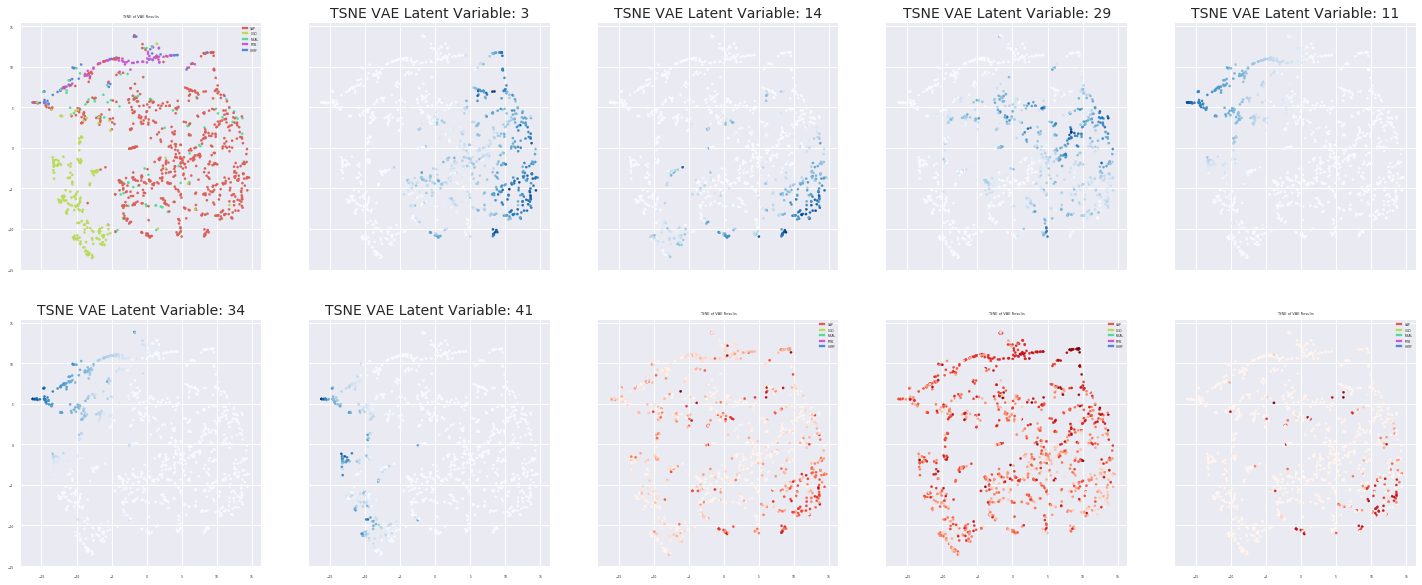

In [43]:
import matplotlib.cm as cm

row = 0
col = 0

important_features = [3,14,29,11,34,41]

fig, axarr = plt.subplots(2,5, figsize=(25, 10), sharex=True, sharey=True, facecolor='white') #v,11
axarr[row,col].scatter(tsne_out['1'], tsne_out['2'], color=[color_dict[i] for i in metadata],s=5 )
axarr[row,col].set_title("TSNE of VAE Results")
axarr[row,col].legend(handles = patches)

count = 0
for i in [3,14,29,11,34,41]:
    count += 1 
    feature_id = i 
    
    col = (count)%5
    if(col) == 0:
        row += 1
    
    axarr[row, col].scatter(tsne_out['1'], tsne_out['2'], c=list(encoded_df[str(i)]), cmap='Blues', s=5) #encoded_df.iloc[:, i]
    axarr[row,col].set_title('TSNE VAE Latent Variable: '+str(feature_id), fontsize=14)

axarr[row,col+1].scatter(tsne_out['1'], tsne_out['2'], c=list(rnaseq_df['Viruses']), cmap='Reds',s=5 )
axarr[row,col+1].set_title("TSNE of VAE Results")
axarr[row,col+1].legend(handles = patches)

#586
axarr[row,col+2].scatter(tsne_out['1'], tsne_out['2'], c=list(rnaseq_df['Bacteria']), cmap='Reds',s=5 )
axarr[row,col+2].set_title("TSNE of VAE Results")
axarr[row,col+2].legend(handles = patches)

axarr[row,col+3].scatter(tsne_out['1'], tsne_out['2'], c=list(rnaseq_df['1868215']), cmap='Reds',s=5 )
axarr[row,col+3].set_title("TSNE of VAE Results")
axarr[row,col+3].legend(handles = patches)

    
plt.savefig('/data/katrina/AutoEncode/tybalt/PDFS/feature_investigation_50LV.pdf')

In [37]:
#encoded_df[str(i)].shape
#list(rnaseq_df['Viruses'])#.shape

In [190]:
from scipy.stats.stats import pearsonr   
print(pearsonr(list(encoded_df[str(3)]),list(rnaseq_df.loc[:,'11244'])))
print(pearsonr(list(encoded_df[str(3)]),list(rnaseq_df.loc[:,'1868215'])))
print(pearsonr(list(encoded_df[str(3)]),list(rnaseq_df.loc[:,'ENSG00000187608.8'])))
#plt.scatter(tsne_out['1'], tsne_out['2'], c=list(rnaseq_df.loc[:,'11244']), cmap='Blues', s=5)
#plt.show()
#plt.scatter(tsne_out['1'], tsne_out['2'], c=list(rnaseq_df.loc[:,'ENSG00000187608.8']), cmap='Blues', s=5) # '1868215'
#plt.show()

(0.2340929260597476, 1.0811852052316595e-15)
(0.23794985067935456, 3.5424922814396168e-16)
(0.25805022268986261, 7.6327317985104048e-19)


13.350126266479492


Text(0.5,1,'VAE TSNE, Sum RSV')

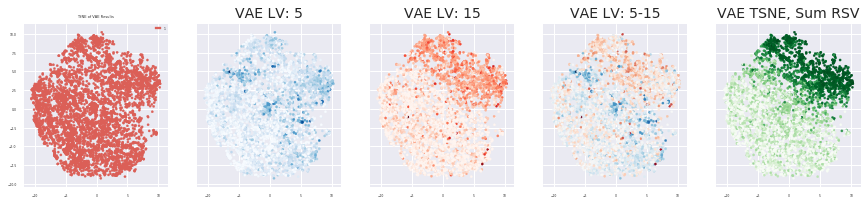

In [64]:
import matplotlib.cm as cm

fig, axarr = plt.subplots(1,5, figsize=(15, 3), sharex=True, sharey=True, facecolor='white') #v,11

axarr[0].scatter(tsne_out['1'], tsne_out['2'], color=[color_dict[i] for i in metadata],s=5 )
axarr[0].set_title("TSNE of VAE Results")
axarr[0].legend(handles = patches)

var1 = 5# 12 #19# 1# 21
var2 = 15#23 #6 #5 #13# 23

max_val = max([max(encoded_df.iloc[:, (var1-1)]), max(encoded_df.iloc[:, (var2-1)])])
print(max_val)
multiplier_var1 = max_val / max(encoded_df.iloc[:, (var1-1)])
multiplier_var2 = max_val / max(encoded_df.iloc[:, (var2-1)])


axarr[1].scatter(tsne_out['1'], tsne_out['2'], c=(encoded_df.iloc[:, (var1-1)]*multiplier_var1), cmap='Blues', s=5)
axarr[1].set_title('VAE LV: '+str((var1)), fontsize=14)

axarr[2].scatter(tsne_out['1'], tsne_out['2'], c=(encoded_df.iloc[:, (var2-1)]*multiplier_var2), cmap='Reds', s=5)
axarr[2].set_title('VAE LV: '+str((var2)), fontsize=14)

axarr[3].scatter(tsne_out['1'], tsne_out['2'], c=(encoded_df.iloc[:, (var1-1)]*multiplier_var1) - 
                 (encoded_df.iloc[:, (var2-1)] * multiplier_var2), cmap='RdBu', s=5)
axarr[3].set_title('VAE LV: '+str(var1) + '-' + str(var2), fontsize=14)

axarr[4].scatter(tsne_out['1'], tsne_out['2'], c=np.log(rnaseq_df.loc[:,['RSV' in i for i in rnaseq_df.columns]].sum(axis=1) + 1), cmap='Greens', s=5)
axarr[4].set_title('VAE TSNE, Sum RSV', fontsize=14)

# third palette should be blue to white to red


In [63]:
import numpy as np

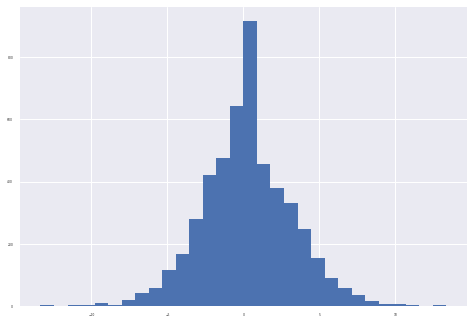

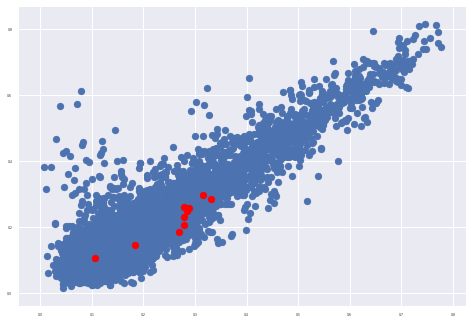

,var1,var2


In [50]:
diff = (encoded_df.iloc[:, (var1-1)]*multiplier_var1) - (encoded_df.iloc[:, (var2-1)] * multiplier_var2)
diff.sort_values(inplace=True)
diff.hist(bins = 30)
plt.show()
var2_overrep = list(diff.head(n=50).index)
var1_overrep = list(diff.tail(n=50).index)

#print(rnaseq_df.loc[var2_overrep,:].mean().head())# + var1_overrep,:].head()
#print(rnaseq_df.loc[var1_overrep,:].mean().head())

plt.scatter(rnaseq_df.loc[var1_overrep,:].mean(), rnaseq_df.loc[var2_overrep,:].mean())
#plt.show()
dic = {'var1':rnaseq_df.loc[var1_overrep,:].mean(), 'var2':rnaseq_df.loc[var2_overrep,:].mean()}
df = pd.DataFrame(dic)
df.head()

plt.scatter(rnaseq_df.loc[var1_overrep,['RSV' in i for i in rnaseq_df.columns]].mean(),
            rnaseq_df.loc[var2_overrep,['RSV' in i for i in rnaseq_df.columns]].mean() , color='red')
plt.show()

df2 = df.loc[df.var1 > 0.4, :]
df2 = df2.loc[df2.var2 < 0.2, :]
#df[df]
df2

In [ ]:
'''from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=4)

# Fitting the input data
kmeans = kmeans.fit(encoded_df)
# Getting the cluster labels
labels = kmeans.predict(encoded_df)
# Centroid values
#centroids = kmeans.cluster_centers_

plt.scatter(tsne_out['1'], tsne_out['2'], c=labels, s=5)
plt.show()


# Fitting the input data
kmeans = kmeans.fit(principalDf)
# Getting the cluster labels
labels = kmeans.predict(principalDf)
# Centroid values
#centroids = kmeans.cluster_centers_

plt.scatter(tsne_out['1'], tsne_out['2'], c=labels, s=5)
plt.show()'''

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(encoded_df).score(encoded_df) for i in range(len(kmeans))]
plt.scatter([i for i in Nc],score)
plt.xlabel('Number of Clusters - VAE')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(principalDf).score(principalDf) for i in range(len(kmeans))]
plt.scatter([i for i in Nc],score)
plt.xlabel('Number of Clusters - PCA')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [ ]:
#correlation plot for gene-wise similarity
sns.set(font_scale=1)
sns.clustermap(weight_layer_df.transpose().corr(), figsize=(12,12))

In [ ]:
sns.clustermap(encoded_df.corr(), figsize=(12,12))

In [ ]:
'''# visualizing cell-specific weights in a particular encoded dimension
plt.figure(figsize=(10, 10))
A = 21
B = 23
plt.scatter(encoded_df.iloc[:, A-1], encoded_df.iloc[:, B-1], color=[color_dict[i] for i in metadata] )
plt.xlabel("Latent Variable " + str(A))
plt.ylabel("Latent Variable " + str(B))

plt.legend(handles = patches)


encoded_df.head(1).plot(kind='bar')


# thinking about how to assign cells to particular latent variables
from collections import Counter
test = encoded_df.idxmax(axis=1)
print(test.head())
#test.where(test=='20')
test_a = pd.Series(Counter([i.split('.')[1] for i in test.index]))
test_b = pd.Series(Counter([i.split('.')[1] for i in test[test=='23'].index]))
print(test_b/test_a)
print(test_b/test_b.sum())'''

### Run PCA on dataset

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
principalComponents = pca.fit_transform(rnaseq_df)
principalDf = pd.DataFrame(data = principalComponents)

In [ ]:
principalDf.shape

In [ ]:
loadings = pca.components_
pca_encodings = pd.DataFrame(loadings)

In [ ]:
pca_encodings.columns = rnaseq_df.columns#
pca_encodings.head()


In [ ]:
# loop through all the encodings, select the "significant genes"
SD_THRESHOLD = 3.5
saved_values2 = {}

for i in range(25):
    A = 1
    B = i+1
    if(B > 1):
        sex_node_plot = pca_encodings.loc[[A, B], :].T
        sex_node_plot.columns = ['encoding '+str(A), 'encoding ' + str(B)]
        sex_node_plot = (sex_node_plot.reindex(sex_node_plot['encoding ' + str(B)].abs().sort_values(ascending=False).index))
        saved_values2[B] = {}

        hw_nodeA_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
        nodeA_df = output_high_weight_genes(sex_node_plot, 'encoding '+str(A), hw_nodeA_file, thresh = SD_THRESHOLD)
        nodeA_df.index

        hw_nodeB_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
        nodeB_df = output_high_weight_genes(sex_node_plot, 'encoding '+str(B), hw_nodeB_file, thresh = SD_THRESHOLD)

        for gene in nodeB_df.index:
            saved_values2[B][gene] = nodeB_df.loc[gene]['encoding '+str(B)]

# FINISH ADDING THE DATA
        
A = 2
B = 1

sex_node_plot = pca_encodings.loc[[A, B], :].T
sex_node_plot.columns = ['encoding '+str(A), 'encoding ' + str(B)]
sex_node_plot = ( sex_node_plot.reindex(sex_node_plot['encoding ' + str(B)].abs().sort_values(ascending=False).index))
saved_values2[B] = {}

hw_nodeA_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
nodeA_df = output_high_weight_genes(sex_node_plot, 'encoding '+str(A), hw_nodeA_file, thresh = SD_THRESHOLD)
nodeA_df.index

hw_nodeB_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
nodeB_df = output_high_weight_genes(sex_node_plot, 'encoding '+str(B), hw_nodeB_file, thresh = SD_THRESHOLD)
for gene in nodeB_df.index:
    saved_values2[B][gene] = nodeB_df.loc[gene]['encoding '+str(B)]

df2 = pd.DataFrame(saved_values2)
df2.fillna(0, inplace=True)
df2.head()
df2 = df2[(df2 != 0).sum(axis=1) > 2]

In [ ]:
df2.shape

In [ ]:
sns.set(font_scale=0.5)
g = sns.clustermap(df2, figsize=(10,50), standard_scale=None)
g.savefig('/data/katrina/AutoEncode/tybalt/OUTPUTS/cluster_pca.pdf')

In [ ]:
import matplotlib.cm as cm

row = 0
col = 0

fig, axarr = plt.subplots(6,5, figsize=(20, 24), sharex=True, sharey=True, facecolor='white') #v,11
axarr[row,col].scatter(tsne_out['1'], tsne_out['2'], color=[color_dict[i] for i in metadata],s=5 )
axarr[row,col].set_title("TSNE of VAE Results")
axarr[row,col].legend(handles = patches)

for i in range(len(principalDf.columns)):
    feature_id = i + 1
    
    col = (i+1)%5
    if(col) == 0:
        row += 1
    
    axarr[row, col].scatter(tsne_out['1'], tsne_out['2'], c=principalDf.iloc[:, i], cmap='Blues', s=5)
    axarr[row,col].set_title('TSNE PCA Latent Variable: '+str(feature_id), fontsize=14)


In [ ]:
# Perform t-SNE on zero-one RNAseq features
tsne_rna = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,
                         learning_rate=300, n_iter=200)
tsne_rna_out = tsne_rna.fit_transform(rnaseq_df)
tsne_rna_out = pd.DataFrame(tsne_rna_out, columns=['1', '2'])
tsne_rna_out.index = rnaseq_df.index
tsne_rna_out.index.name = 'tcga_id'
tsne_rna_out_file = os.path.join('results', 'rnaseq_tsne_features.tsv')
tsne_rna_out.to_csv(tsne_rna_out_file, sep='\t')
tsne_rna_out.head(2)

In [ ]:
tsne_rna_out.plot.scatter('1','2', figsize=(12,12), s=15, color=[color_dict[i] for i in metadata] ) #[['red','blue'][int(i)] for i in (rnaseq_df[rnaseq_df.columns[['flu' in i for i in rnaseq_df.columns]]].sum(axis=1) > 0)])# 
plt.title("TSNE of PCA Results")
plt.legend(handles = patches)

In [ ]:
import matplotlib.cm as cm

row = 0
col = 0

fig, axarr = plt.subplots(6,5, figsize=(20, 24), sharex=True, sharey=True, facecolor='white') #v,11
axarr[row,col].scatter(tsne_rna_out['1'], tsne_rna_out['2'], color=[color_dict[i] for i in metadata],s=5 )
axarr[row,col].set_title("TSNE of PCA Results")
axarr[row,col].legend(handles = patches)

for i in range(len(principalDf.columns)):
    feature_id = i + 1
    
    col = (i+1)%5
    if(col) == 0:
        row += 1
    
    axarr[row, col].scatter(tsne_rna_out['1'], tsne_rna_out['2'], c=principalDf.iloc[:, i], cmap='Blues', s=5)
    axarr[row,col].set_title('TSNE PCA Latent Variable: '+str(feature_id), fontsize=14)


### Inverting the above analysis...
TSNE projected by PCA, but coloring by VAE

In [ ]:
import matplotlib.cm as cm

row = 0
col = 0

fig, axarr = plt.subplots(6,5, figsize=(20, 24), sharex=True, sharey=True, facecolor='white') #v,11
axarr[row,col].scatter(tsne_rna_out['1'], tsne_rna_out['2'], color=[color_dict[i] for i in metadata],s=5 )
axarr[row,col].set_title("TSNE of PCA Results")
axarr[row,col].legend(handles = patches)

for i in range(len(principalDf.columns)):
    feature_id = i + 1
    
    col = (i+1)%5
    if(col) == 0:
        row += 1
    
    axarr[row, col].scatter(tsne_rna_out['1'], tsne_rna_out['2'], c=encoded_df.iloc[:, i], cmap='Blues', s=5)
    axarr[row,col].set_title('TSNE PCA Latent Variable: '+str(feature_id), fontsize=14)
